画像

In [1]:
!pip install gymnasium-robotics
!pip install matplotlib
!pip install 'numpy<2.0'
!pip install stable_baselines3
!pip install opencv-python
!pip install tensorboard
!pip install einops
!pip install tqdm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [2]:
# torch.deviceを定義．この変数は後々モデルやデータをGPUに転送する時にも使います
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
!nvidia-smi

Thu Dec 12 03:51:36 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.72                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
|  0%   29C    P8              3W /  450W |     941MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import gc
import os
import time
from typing import Any, List, Tuple

import gymnasium as gym
import gymnasium_robotics

import matplotlib.pyplot as plt
import numpy as np
# import pybullet_envs  # PyBulletの環境をgymに登録する
import torch
from torch import nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.tensorboard import SummaryWriter
from einops import rearrange
import cv2

# 可視化のためにTensorBoardを用いるので，Colab上でTensorBoardを表示するための宣言を行う
%load_ext tensorboard

-2.832967915172884


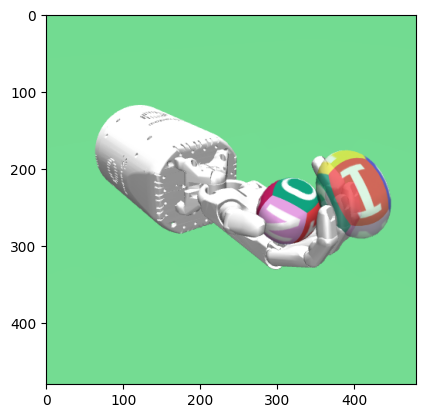

-2.826333407067602


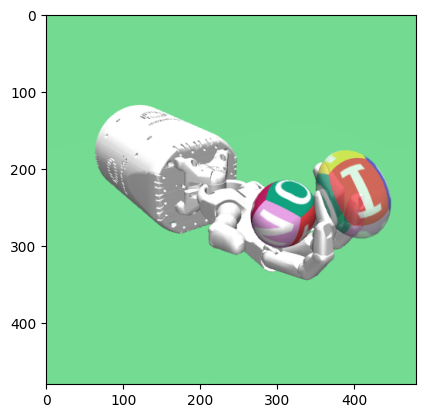

-2.9072626221362077


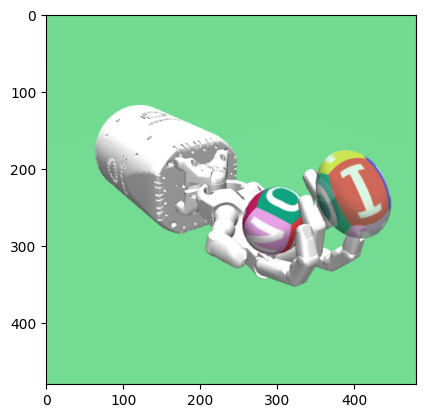

-2.83393476881616


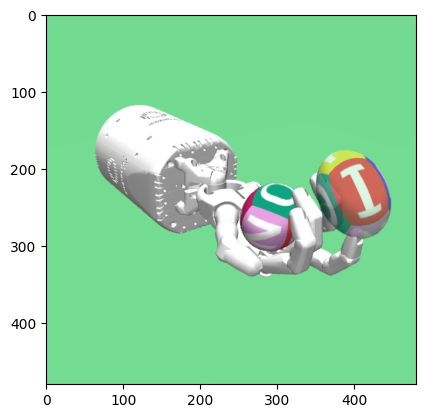

-2.827224282932752


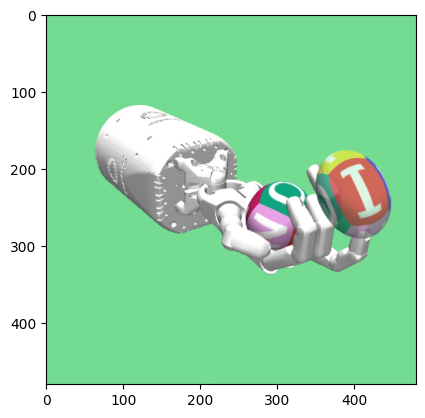

In [5]:
gym.register_envs(gymnasium_robotics)
env = gym.make('HandManipulateEggDense-v1', render_mode="rgb_array", max_episode_steps=100)

observation, info = env.reset(seed=42)
for _ in range(5):
    action = env.action_space.sample()  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action)
    print(reward)

    img = env.render()
    plt.imshow(img)
    plt.show()

In [6]:
reward

-2.827224282932752

In [7]:
env.observation_space['observation'].shape

(61,)

 この環境のアクションは、手の各関節の目標角度を指定する連続値のベクトルで構成されています。各要素は対応する関節の目標角度を表し、一般的に-1から1の範囲で正規化されています。これらの値は、実際の関節角度にマッピングされ、手の動作を制御します。(ChatGPT)

In [8]:
action

array([-0.02684139, -0.23956802,  0.06147933,  0.501062  ,  0.23482285,
        0.83585304, -0.8016095 ,  0.8869028 , -0.85861087, -0.7479589 ,
        0.08291645, -0.1747504 ,  0.53786916,  0.61902076,  0.23164597,
       -0.31153068,  0.3972143 ,  0.15883864,  0.5090395 , -0.98082536],
      dtype=float32)

観測（オブザベーション）: 観測は、手の状態、物体の状態、目標状態、そしてタッチセンサーの情報を含むベクトルです。具体的には、以下の情報が含まれます：

- 手の関節角度と速度: 各関節の現在の角度とその変化率。
- 物体の位置と回転: 操作対象である卵の現在の位置と回転状態。
- 目標位置と回転: 卵が達成すべき目標の位置と回転状態。
- タッチセンサーの状態: 各センサーが接触を検出しているかどうかを示すブール値。

**タッチセンサの状態を表す後半が0となっているため，修正が必要** \
考えられる原因
- 環境がうまく動かせていない（gymnasiumの干渉？）
- エピソードが途中で終わっている

In [9]:
observation

{'observation': array([-1.20020757e-01, -2.67209582e-01,  3.64094732e-02,  8.90361844e-01,
         8.69747904e-01,  8.44997160e-01,  1.24861271e-01,  8.72043186e-01,
         9.09845478e-01,  8.73800134e-01, -2.33298331e-02,  2.88711536e-01,
         7.58769122e-01,  7.02232781e-01,  4.17285614e-01,  9.83408995e-02,
         7.58516057e-01,  8.13527981e-01,  7.76024020e-01,  1.12627656e-01,
         4.10096293e-01, -1.11173830e-02, -1.06990807e-02, -1.19815958e+00,
        -8.27852230e-01, -3.56665651e-01, -2.10603512e-02,  2.36299193e+00,
         2.07070564e-01,  2.91494851e-01,  1.76845695e+00, -7.52523710e+00,
         2.11584339e+00,  2.28126224e+00, -2.87231865e+00, -1.15066044e+00,
         1.85918134e-01,  7.23789365e-01, -1.23796841e+00,  1.09865803e+00,
         5.24355134e+00,  7.18871723e-01,  6.83786544e-01, -4.45864758e+00,
         4.44769286e+00,  4.43625639e-01,  2.73122237e+00, -3.91073164e+00,
         1.35084393e-01,  1.88771302e-02, -3.43223650e-04,  8.30419672e-0

### 環境Wrapperを作成

In [10]:
class GymWrapper(object):
    """
    PyBullet環境のためのラッパー
    """

    metadata = {"render.modes": ["human", "rgb_array"]}
    reward_range = (-np.inf, np.inf)

    # 　同時に画像の大きさも変更できるようにします
    def __init__(
        self,
        env: gym.Env,
        render_width: int = 64,
        render_height: int = 64,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        env : gym.Env
            gymで提供されている環境のインスタンス．
        render_width : int
            観測画像の幅．
        render_height : int
            観測画像の高さ．
        """
        self._env = env

        self._render_width = render_width
        self._render_height = render_height

    def __getattr(self, name: str) -> Any:
        """
        環境が保持している属性値を取得するメソッド．

        Parameters
        ----------
        name : str
            取得したい属性値の名前．

        Returns
        -------
        _env.name : Any
            環境が保持している属性値．
        """
        return getattr(self._env, name)

    @property
    def observation_space(self) -> gym.spaces.Box:
        """
        観測空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            観測空間に関する情報（各画素値の最小値，各画素値の最大値，観測データの形状， データの型）．
        """
        width = self._render_width
        height = self._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self) -> gym.spaces.Box:
        """
        行動空間に関する情報を取得するメソッド．

        Returns
        -------
        space : gym.spaces.Box
            行動空間に関する情報（各行動の最小値，各行動の最大値，行動空間の次元， データの型） ．
        """
        return self._env.action_space

    # 　元の観測（低次元の状態）は今回は捨てて，env.render()で取得した画像を観測とします.
    #  画像，報酬，終了シグナルが得られます.
    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．

        Parameters
        ----------
        action : np.dnarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            行動を与えたときの次の観測．
        reward : float
            行動を与えたときに得られる報酬．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        _, reward, terminated, truncated, info = self._env.step(action)
        obs = self._env.render()
        obs = cv2.resize(obs, (self._render_height, self._render_width), interpolation=cv2.INTER_LINEAR)
        return obs, reward, terminated, truncated, info

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (height, width, 3)
            環境をリセットしたときの初期の観測．
        """
        self._env.reset()
        obs = self._env.render()
        return obs

    def render(self, **kwargs) -> np.ndarray:
        """
        観測をレンダリングするためのメソッド．

        Parameters
        ----------
        Returns
        -------
        obs : np.ndarray (height, width, 3)
            観測をレンダリングした結果．
        """
        return self._env.render(**kwargs)

    def close(self) -> None:
        """
        環境を閉じるためのメソッド．
        """
        self._env.close()

In [11]:
class RepeatAction(GymWrapper):
    """
    同じ行動を指定され
    た回数自動的に繰り返すラッパー．観測は最後の行動に対応するものになる
    """

    def __init__(self, env: GymWrapper, skip: int = 4) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        skip : int
            同じ行動を繰り返す回数．
        """
        # gym.Wrapper.__init__(self, env)
        super().__init__(env, render_width=env._render_width, render_height=env._render_height)
        self._skip = skip

    def reset(self) -> np.ndarray:
        """
        環境をリセットするためのメソッド．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            環境をリセットしたときの初期の観測．
        """
        obs = self._env.reset()
        obs = cv2.resize(obs, (self._render_height, self._render_width), interpolation=cv2.INTER_LINEAR)
        return obs

    def step(self, action: np.ndarray) -> (np.ndarray, float, bool, dict):
        """
        環境に行動を与え次の観測，報酬，終了フラグを取得するメソッド．
        与えられた行動をskipの回数だけ繰り返した結果を返す．

        Parameters
        ----------
        action : np.ndarray (action_dim, )
            与える行動．

        Returns
        -------
        obs : np.ndarray (width, height, 3)
            行動をskipの回数だけ繰り返したあとの観測．
        total_reawrd : float
            行動をskipの回数だけ繰り返したときの報酬和．
        done : bool
            エピソードが終了したかどうか表すフラグ．
        info : dict
            その他の環境に関する情報．
        """
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self._env.step(action)
            obs = cv2.resize(obs, (self._render_height, self._render_width), interpolation=cv2.INTER_LINEAR)
            total_reward += reward
            # if done:
            #     break
        return obs, total_reward, terminated, truncated, info

In [16]:
def make_env() -> RepeatAction:
    """
    作成たラッパーをまとめて適用して環境を作成する関数．

    Returns
    -------
    env : RepeatAction
        ラッパーを適用した環境．
    """
    gym.register_envs(gymnasium_robotics)
    env = gym.make('HandManipulateEggDense-v1', render_mode="rgb_array", max_episode_steps=100)

    # Dreamerでは観測は64x64のRGB画像
    env = GymWrapper(
        env, render_width=64, render_height=64
    )
    env = RepeatAction(env, skip=2)  # DreamerではActionRepeatは2
    return env

-8.124559846335952


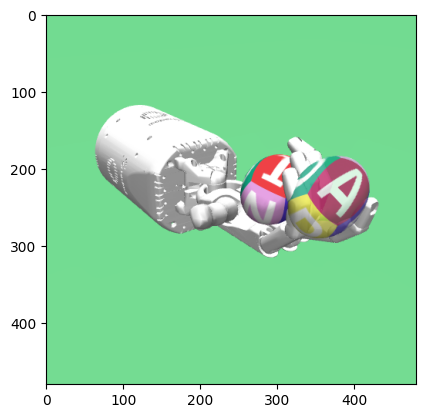

-8.372929559181022


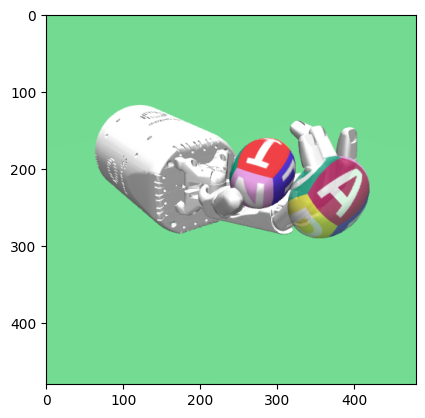

-8.630855818411279


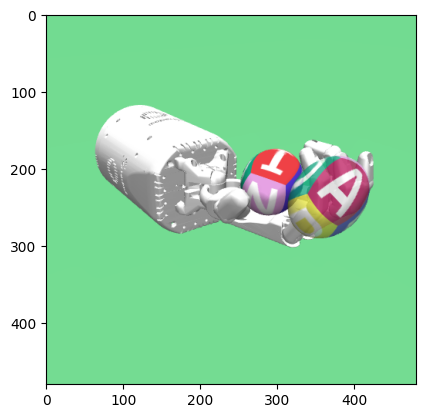

-8.963236745058815


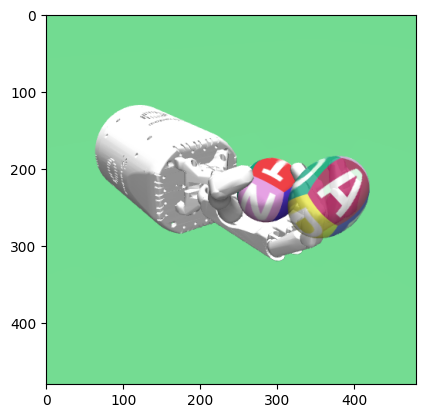

-8.739295525209908


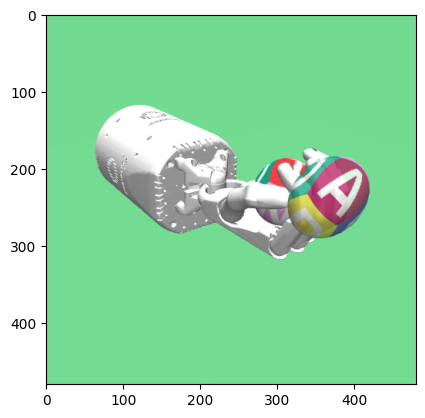

In [17]:
gym.register_envs(gymnasium_robotics)
env = make_env()
env.reset()
for _ in range(5):
    action = env.action_space.sample()  # User-defined policy function
    observation, reward, terminated, truncated, info = env.step(action)
    print(reward)

    img = env.render()
    plt.imshow(img)
    plt.show()

### classの作成

In [18]:
class TransitionModel(nn.Module):
    """
    状態遷移を担うクラス．このクラスは複数の要素を含んでいます．
    決定的状態遷移 （RNN) : h_t+1 = f(h_t, s_t, a_t)
    確率的状態遷移による1ステップ予測として定義される "prior" : p(s_t+1 | h_t+1)
    観測の情報を取り込んで定義される "posterior": q(s_t+1 | h_t+1, e_t+1)
    """

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        rnn_hidden_dim: int,
        hidden_dim: int = 200,
        min_stddev: float = 0.1,
        act: "function" = F.elu,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        action_dim : int
            行動空間の次元数．
        rnn_hidden_dim : int
            決定的状態遷移を計算するRNNの隠れ層の次元数．
        hidden_dim : int
            決定的状態hの次元数．
        min_stddev : float
            確率状態遷移の標準偏差の最小値．
        act : function
            活性化関数．
        """
        super(TransitionModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.fc_state_action = nn.Linear(state_dim + action_dim, hidden_dim)

        self.fc_rnn_hidden = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc_state_mean_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_rnn_hidden_embedded_obs = nn.Linear(rnn_hidden_dim + 1024, hidden_dim)
        self.fc_state_mean_posterior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_posterior = nn.Linear(hidden_dim, state_dim)

        # next hidden stateを計算
        self.rnn = nn.GRUCell(hidden_dim, rnn_hidden_dim)
        self._min_stddev = min_stddev
        self.act = act

    def forward(
        self,
        state: torch.Tensor,
        action: torch.Tensor,
        rnn_hidden: torch.Tensor,
        embedded_next_obs: torch.Tensor,
    ) -> Tuple[torch.Tensor]:
        """
        prior p(s_t+1 | h_t+1) と posterior q(s_t+1 | h_t+1, e_t+1) を返すメソッド．
        この2つが近づくように学習する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            時刻tの状態(s_t)．
        action : torch.Tensor (batch size, action dim)
            時刻tの行動(a_t)．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t)．
        embedded_next_obs : torch.Tensor (batch size, 1024)
            時刻t+1の観測をエンコードしたもの(e_t+1)．

        Returns
        -------
        next_state_prior : torch.Tensor (batch size, state dim)
            prior(p(s_t+1 | h_t+1))による次の時刻の状態の予測．
        next_state_posterior : torch.Tensor (batch size, state dim)
            posterior(q(s_t+1 | h_t+1, e_t+1))による次の時刻の状態の予測．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持する次の決定的状態(h_t+1)．
        """
        next_state_prior, rnn_hidden = self.prior(
            self.recurrent(state, action, rnn_hidden)
        )
        next_state_posterior = self.posterior(rnn_hidden, embedded_next_obs)
        return next_state_prior, next_state_posterior, rnn_hidden

    def recurrent(
        self, state: torch.Tensor, action: torch.Tensor, rnn_hidden: torch.Tensor
    ) -> torch.Tensor:
        """
        決定的状態 h_t+1 = f(h_t, s_t, a_t)を計算するメソッド．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            時刻tの状態(s_t)．
        action : torch.Tensor (batch size, action dim)
            時刻tの行動(a_t)．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t)．

        Returns
        -------
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持する次の決定的状態(h_t+1)．
        """
        hidden = self.act(self.fc_state_action(torch.cat([state, action], dim=1)))
        # h_t+1を求める
        rnn_hidden = self.rnn(hidden, rnn_hidden)
        return rnn_hidden

    def prior(self, rnn_hidden: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        prior p(s_t+1 | h_t+1) を計算するメソッド．

        Parameters
        ----------
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t+1)．

        Returns
        -------
        state : torch.Tensor (batch size, state dim)
            決定的状態を用いてサンプリングされた確率的な状態(s_t+1)．
            ここでは決定的状態h_t+1からガウス分布の平均，標準偏差を推定してサンプリングしています．
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持する決定的状態(h_t+1)．
            入力からのものをそのまま返しています．
        """
        #h_t+1を求める（ヒント: self.act, self.fc_rnn_hiddenを使用）
        hidden = self.act(self.fc_rnn_hidden(rnn_hidden)) # WRITE ME

        mean = self.fc_state_mean_prior(hidden)
        stddev = F.softplus(self.fc_state_stddev_prior(hidden)) + self._min_stddev
        return Normal(mean, stddev), rnn_hidden

    def posterior(
        self, rnn_hidden: torch.Tensor, embedded_obs: torch.Tensor
    ) -> torch.Tensor:
        """
        posterior q(s_t+1 | h_t+1, e_t+1)  を計算するメソッド．

        Parameters
        ----------
        rnn_hidden : torch.Tensor (batch size, rnn hidden dim)
            RNNが保持している決定的状態(h_t+1)．
        embedded_obs : torch.Tensor (batch size, 1024)
            時刻t+1の観測をエンコードしたもの．

        Returns
        -------
        state : torch.Tensor (batch size, state dim)
            決定的状態とエンコードした観測を用いてサンプリングされた確率的な状態(s_t+1)．
            ここでは決定的状態h_t+1とエンコードした観測e_t+1からガウス分布の平均，標準偏差を推定してサンプリングしています．
        """
        # h_t+1，o_t+1を結合し，q(s_t+1 | h_t+1, e_t+1) を計算する
        hidden = self.act(self.fc_rnn_hidden_embedded_obs(torch.cat([rnn_hidden, embedded_obs], dim=1))) # WRITE ME
        mean = self.fc_state_mean_posterior(hidden)
        stddev = F.softplus(self.fc_state_stddev_posterior(hidden)) + self._min_stddev
        return Normal(mean, stddev)

In [19]:
class ObservationModel(nn.Module):
    """
    p(o_t | s_t, h_t)
    低次元の状態表現から画像を再構成するデコーダ (3, 64, 64)
    """

    def __init__(self, state_dim: int, rnn_hidden_dim: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        """
        super(ObservationModel, self).__init__()
        self.fc = nn.Linear(state_dim + rnn_hidden_dim, 1024)
        self.dc1 = nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2)
        self.dc2 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2)
        self.dc3 = nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2)
        self.dc4 = nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2)

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．確率的状態sと決定的状態hから観測を再構成する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．

        Returns
        -------
        obs : torch.Tensor (batch size, 3, 64, 64)
            再構成された観測o．
        """
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 1024, 1, 1)
        hidden = F.relu(self.dc1(hidden))
        hidden = F.relu(self.dc2(hidden))
        hidden = F.relu(self.dc3(hidden))
        obs = self.dc4(hidden)
        return obs

In [20]:
class RewardModel(nn.Module):
    """
    p(r_t | s_t, h_t)
    低次元の状態表現から報酬を予測する．
    """

    def __init__(
        self,
        state_dim: int,
        rnn_hidden_dim: int,
        hidden_dim: int = 400,
        act: "function" = F.elu,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        hidden_dim : int
            報酬モデルの隠れ層の次元数． (default=400)
        act : function
            報酬モデルに利用される活性化関数． (default=torch.nn.functional.elu)
        """
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．確率的状態sと決定的状態hから報酬rを推定する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．

        Returns
        -------
        reward : torch.Tensor (batch size, 1)
            確率的状態s，決定的状態hに対する報酬r．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        reward = self.fc4(hidden)
        return reward

In [21]:
class RSSM:
    """
    TransitionModel, ObservationModel, RewardModelの3つをまとめたRSSMクラス．
    """

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        rnn_hidden_dim: int,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        action_dim : int
            行動空間の次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        """
        self.transition = TransitionModel(state_dim, action_dim, rnn_hidden_dim).to(
            device
        )
        self.observation = ObservationModel(
            state_dim,
            rnn_hidden_dim,
        ).to(device)
        self.reward = RewardModel(
            state_dim,
            rnn_hidden_dim,
        ).to(device)

In [22]:
# こちらはDQNのReplayBufferの定義
class ReplayBuffer:
    """
    これまでの経験をためておくリプレイバッファ．
    """

    def __init__(self, memory_size: int) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        memory_size : int
            リプレイバッファに貯められるデータの上限．
        """
        self.memory_size = memory_size
        # 収集する経験は上限を決め古いものから削除する．
        self.memory = deque([], maxlen=memory_size)

    def append(self, transition: dict) -> None:
        """
        環境から得た経験（状態，行動，次の状態，報酬，終了フラグ）をキューに追加するメソッド．
        dequeを用いているため上限(memory_size)に達すると古いものが削除される．

        Parameters
        ----------
        trainsition : dict
            状態(state)，次の状態(next_state)，報酬(reward)，行動(action)，終了フラグ(done)を格納した辞書．
        """
        self.memory.append(transition)

    def sample(self, batch_size: int) -> dict:  # 貯めた経験の中からランダムにミニバッチ単位で経験を取り出す．
        """
        バッファに貯めた経験の中からランダムにミニバッチ単位で経験を取り出すメソッド．

        Parameters
        ----------
        batch_size : int
            バッチサイズ．

        Returns
        -------
        sample : dict
            状態(states)，次の状態(next_states)，報酬(rewards)，行動(actions)，終了フラグ(dones)をバッチサイズ分だけ格納した辞書．
        """
        batch_indexes = np.random.randint(0, len(self.memory), size=batch_size)
        states = np.array([self.memory[index]["state"] for index in batch_indexes])
        next_states = np.array(
            [self.memory[index]["next_state"] for index in batch_indexes]
        )
        rewards = np.array([self.memory[index]["reward"] for index in batch_indexes])
        actions = np.array([self.memory[index]["action"] for index in batch_indexes])
        dones = np.array([self.memory[index]["terminated"] for index in batch_indexes])
        return {
            "states": states,
            "next_states": next_states,
            "rewards": rewards,
            "actions": actions,
            "dones": terminated,
        }

In [23]:
# 　今回のReplayBuffer
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ．
    """

    def __init__(
        self, capacity: int, observation_shape: List[int], action_dim: int
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        capacity : int
            リプレイバッファにためておくことができる経験の上限．
        observation_shape : List[int]
            環境から与えられる観測の形状．
        action_dim : int
            行動空間の次元数．
        """
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)
        # self.done = np.zeros((capacity, 1), dtype=np.bool)

        self.index = 0
        self.is_filled = False

    def push(
        self, observation: np.ndarray, action: np.ndarray, reward: float, done: bool
    ) -> None:
        """
        リプレイバッファに経験を追加するメソッド．

        Parameters
        ----------
        observation : np.ndarray (64, 64, 3)
            環境から得られた観測．
        action : np.ndarray (action_dim, )
            エージェントがとった（もしくは経験を貯める際のランダムな）行動．
        reward : float
            観測に対して行動をとったときに得られる報酬．
        done : bool
            エピソードが終了するかどうかのフラグ．
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し，最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size: int, chunk_length: int) -> Tuple[np.ndarray]:
        """
        経験をリプレイバッファからサンプルします．（ほぼ）一様なサンプルです．
        結果として返ってくるのは観測（画像），行動，報酬，終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です．
        各バッチは連続した経験になっています．
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります．

        Parameters
        ----------
        batch_size : int
            バッチサイズ．
        chunk_length : int
            バッチあたりの系列長．


        Returns
        -------
        sampled_observations : np.ndarray (batch size, chunk length, 3, 64, 64)
            バッファからサンプリングされた観測．
        sampled_actions : np.ndarray (batch size, chunk length, action dim)
            バッファからサンプリングされた行動．
        sampled_rewards : np.ndarray (batch size, chunk length, 1)
            バッファからサンプリングされた報酬．
        sampled_rewards : np.ndarray (batch size, chunk length, 1)
            バッファからサンプリングされたエピソードの終了フラグ．
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(
                    initial_index <= episode_borders, episode_borders < final_index
                ).any()  # 論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:]
        )
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1]
        )
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1
        )
        sampled_done = self.done[sampled_indexes].reshape(batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self) -> int:
        """
        バッファに貯められている経験の数を返すメソッド．

        Returns
        -------
        length : int
            バッファに貯められている経験の数．
        """
        return self.capacity if self.is_filled else self.index

次に観測の前処理を行う関数を実装します．ちなみに，これもラッパーとして最初から適用してしまわないのは，リプレイバッファにはより容量の小さなnp．uint8の形式で保存しておきたいためです．

In [24]:
def preprocess_obs(obs: np.ndarray) -> np.ndarray:
    """
    画像を正規化する．[0, 255] -> [-0.5, 0.5]．

    Parameters
    ----------
    obs : np.ndarray (64, 64, 3) or (chank length, batch size, 64, 64, 3)
        環境から得られた観測．画素値は[0, 255]．

    Returns
    -------
    normalized_obs : np.ndarray (64, 64, 3) or (chank length, batch size, 64, 64, 3)
        画素値を[-0.5, 0.5]で正規化した観測．
    """
    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

Dreamerでは価値関数の学習を行いますが，このために通常のTD誤差ではなく，**TD(λ)をベースにしたλ-return**としてターゲット価値を計算し，それと現在の予測価値の誤差を用います．そのためにλ-returnを計算する関数をここで実装しておきます．

In [25]:
def lambda_target(
    rewards: torch.Tensor, values: torch.Tensor, gamma: float, lambda_: float
) -> torch.Tensor:
    """
    価値関数の学習のためのλ-returnを計算する関数．

    Parameters
    ----------
    rewards : torch.Tensor (imagination_horizon, batch size * (chank length - 1))
        報酬モデルによる報酬の推定値．
    values : torch.Tensor (imagination_horizon, batch size * (chank length - 1))
        価値関数を近似するValueモデルによる状態価値観数の推定値．
    gamma : float
        割引率．
    lambda_ : float
        λ-returnのパラメータλ．

    V_lambda : torch.Tensor (imagination_horizon, batch size * (chank length - 1))
        各状態に対するλ-returnの値．
    """
    V_lambda = torch.zeros_like(rewards, device=rewards.device)

    H = rewards.shape[0] - 1
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H]
    for n in range(1, H + 1):
        # まずn-step returnを計算します
        # 注意: 系列が途中で終わってしまったら，可能な中で最大のnを用いたn-stepを使います
        V_n[:-n] = (gamma**n) * values[n:]
        for k in range(1, n + 1):
            if k == n:
                V_n[:-n] += (gamma ** (n - 1)) * rewards[k:]
            else:
                V_n[:-n] += (gamma ** (k - 1)) * rewards[k : -n + k]

        # lambda_でn-step returnを重みづけてλ-returnを計算します
        if n == H:
            V_lambda += (lambda_ ** (H - 1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n - 1)) * V_n

    return V_lambda

In [26]:
class Encoder(nn.Module):
    """
    (3, 64, 64)の画像を(1024,)のベクトルに変換するエンコーダクラス．
    """

    def __init__(self) -> None:
        """
        コンストラクタ．
        層の定義のみを行う．
        """
        super(Encoder, self).__init__()
        self.cv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2)
        self.cv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.cv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.cv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．観測画像をベクトルに埋め込む．

        Parameters
        ----------
        obs : torch.Tensor (batch size, 3, 64, 64)
            環境から得られた観測画像．

        Returns
        -------
        embedded_obs : torch.Tensor (batch size, 1024)
            観測を1024次元のベクトルに埋め込んだもの．
        """
        hidden = F.relu(self.cv1(obs))
        hidden = F.relu(self.cv2(hidden))
        hidden = F.relu(self.cv3(hidden))
        embedded_obs = F.relu(self.cv4(hidden)).reshape(hidden.size(0), -1)
        return embedded_obs

In [27]:
class ValueModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から状態価値を出力するクラス．
    """

    def __init__(
        self,
        state_dim: int,
        rnn_hidden_dim: int,
        hidden_dim: int = 400,
        act: "function" = F.elu,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        hidden_dim : int
            モデルの隠れ層の次元数． (default=400)
        act : function
            モデルの活性化関数． (default=torch.nn.functional.elu)
        """
        super(ValueModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state: torch.Tensor, rnn_hidden: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．低次元の状態表現から状態価値を推定する．

        Parameters
        ----------
        state : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．

        Returns
        -------
        state_value : torch.Tensor (batch size, 1)
            入力された状態に対する状態価値の推定値．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        state_value = self.fc4(hidden)
        return state_value

In [28]:
class ActionModel(nn.Module):
    """
    低次元の状態表現(state_dim + rnn_hidden_dim)から行動を計算するクラス．
    """

    def __init__(
        self,
        state_dim: int,
        rnn_hidden_dim: int,
        action_dim: int,
        hidden_dim: int = 400,
        act: "function" = F.elu,
        min_stddev: float = 1e-4,
        init_stddev: float = 5.0,
    ) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        state_dim : int
            確率的状態sの次元数．
        rnn_hidden_dim : int
            決定的状態hの次元数．
        action_dim : int
            行動空間の次元数．
        hidden_dim : int
            モデルの隠れ層の次元数． (default=400)
        act : function
            モデルの活性化関数． (default=torch.nn.functional.elu)
        min_stddev : float
            行動をサンプリングする分布の標準偏差の最小値． (default=1e-4)
        init_stddev : float
            行動をサンプリングする分布の標準偏差の初期値． (default=5.0)
        """
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)
        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = np.log(np.exp(init_stddev) - 1)

    def forward(
        self, state: torch.Tensor, rnn_hidden: torch.Tensor, training: bool = True
    ) -> None:
        """
        順伝播を行うメソッド．入力された状態に対する行動を出力する．
        training=Trueなら，NNのパラメータに関して微分可能な形の行動のサンプル（Reparametrizationによる）を返す．
        training=Falseなら，行動の確率分布の平均値を返す．

        Parameters
        ----------
        staet : torch.Tensor (batch size, state dim)
            確率的状態s．
        rnn_hidden : torch.Tensor (batch size, rnn_hidden_dim)
            決定的状態h．
        training : bool
            訓練か推論かを示すフラグ． (default=True)

        Returns
        -------
        action : torch.Tensor (batch size, action dim)
            入力された状態に対する行動．
            training=Trueでは微分可能な形の行動をサンプリングした値，
            training=Falseでは行動の確率分布の平均値を返す．
        """
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        # Dreamerの実装に合わせて少し平均と分散に対する簡単な変換が入っています
        mean = self.fc_mean(hidden)
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.fc_stddev(hidden)
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if training:
            action = torch.tanh(Normal(mean, stddev).rsample())  # 微分可能にするためrsample()
        else:
            action = torch.tanh(mean)
        return action

In [29]:
class Agent:
    """
    ActionModelに基づき行動を決定する．そのためにRSSMを用いて状態表現をリアルタイムで推論して維持するクラス．
    """

    def __init__(self, encoder: Encoder, rssm: RSSM, action_model: ActionModel) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        encoder : Encoder
            上で定義したEncoderクラスのインスタンス．
            観測画像を1024次元のベクトルに埋め込む ．
        rssm : RSSM
            上で定義したRSSMクラスのインスタンス．
            遷移モデル，1024次元のベクトルを観測画像にするデコーダ，報酬を予測するモデルを持つ．
        action_model : ActionModel
            上で定義したActionModelのインスタンス．
            低次元の状態表現から行動を予測する．
        """
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs: np.ndarray, training=True) -> np.ndarray:
        """
        特殊メソッド．
        インスタンスに直接引数を渡すことで実行される．
        （例）agent = Agent(*args)
             action = agent(obs)  # このときに__call__メソッドが呼び出される．

        Parameters
        ----------
        obs : np.ndarray (batch size, 3, 64, 64)
            環境から得られた観測画像．
        training : bool
            訓練か推論かを示すフラグ． (default=True)

        Returns
        -------
        action : np.ndarray (batch size, action dim)
            入力された観測に対する行動の予測．
        """
        # preprocessを適用，PyTorchのためにChannel-Firstに変換
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            # 観測を低次元の表現に変換し，posteriorからのサンプルをActionModelに入力して行動を決定する
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample()
            action = self.action_model(state, self.rnn_hidden, training=training)

            # 次のステップのためにRNNの隠れ状態を更新しておく
            _, self.rnn_hidden = self.rssm.prior(
                self.rssm.recurrent(state, action, self.rnn_hidden)
            )

        return action.squeeze().cpu().numpy()

    def reset(self) -> None:
        """
        RNNの隠れ状態（=決定的状態）をリセットする．
        """
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

In [30]:
# リプレイバッファの宣言
buffer_capacity = 200000  # Colabのメモリの都合上，元の実装より小さめにとっています
replay_buffer = ReplayBuffer(
    capacity=buffer_capacity,
    observation_shape=(64,64,3),
    action_dim=env.action_space.shape[0],
)

# モデルの宣言
state_dim = 30  # 確率的状態の次元
rnn_hidden_dim = 200  # 決定的状態（RNNの隠れ状態）の次元
# 確率的状態の次元と決定的状態（RNNの隠れ状態）の次元は一致しなくて良い
encoder = Encoder().to(device)
rssm = RSSM(
    state_dim,
    env.action_space.shape[0],
    rnn_hidden_dim,
)
value_model = ValueModel(state_dim, rnn_hidden_dim).to(device)
action_model = ActionModel(state_dim, rnn_hidden_dim, env.action_space.shape[0]).to(
    device
)

# オプティマイザの宣言
model_lr = 6e-4  # encoder, rssm, obs_model, reward_modelの学習率
value_lr = 8e-5
action_lr = 8e-5
eps = 1e-4
model_params = (
    list(encoder.parameters())
    + list(rssm.transition.parameters())
    + list(rssm.observation.parameters())
    + list(rssm.reward.parameters())
)
model_optimizer = torch.optim.Adam(model_params, lr=model_lr, eps=eps)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=value_lr, eps=eps)
action_optimizer = torch.optim.Adam(action_model.parameters(), lr=action_lr, eps=eps)

# その他ハイパーパラメータ
seed_episodes = 5  # 最初にランダム行動で探索するエピソード数
all_episodes = 100  # 学習全体のエピソード数（300ほどで，ある程度収束します） 300に変更
test_interval = 10  # 何エピソードごとに探索ノイズなしのテストを行うか
model_save_interval = 20  # NNの重みを何エピソードごとに保存するか
collect_interval = 100  # 何回のNNの更新ごとに経験を集めるか（＝1エピソード経験を集めるごとに何回更新するか）

action_noise_var = 0.3  # 探索ノイズの強さ

batch_size = 50
chunk_length = 50  # 1回の更新で用いる系列の長さ
imagination_horizon = 15  # Actor-Criticの更新のために，Dreamerで何ステップ先までの想像上の軌道を生成するか


gamma = 0.9  # 割引率
lambda_ = 0.95  # λ-returnのパラメータ
clip_grad_norm = 100  # gradient clippingの値
free_nats = 3  # KL誤差（RSSMのTransitionModelにおけるpriorとposteriorの間の誤差）がこの値以下の場合，無視する

In [31]:
replay_buffer.index

0

In [32]:
from tqdm.notebook import tqdm
env = make_env()
for episode in tqdm(range(seed_episodes)):
    obs = env.reset()
    terminated = False
    for i in range(all_episodes): #all_episodesの数だけ繰り返してエピソードを集める
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, _ = env.step(action)
        replay_buffer.push(obs, action, reward, terminated)
        obs = next_obs

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
log_dir = "logs"
writer = SummaryWriter(log_dir)

In [34]:
for episode in range(seed_episodes, all_episodes):
    # -----------------------------
    #      経験を集める
    # -----------------------------
    start = time.time()
    # 行動を決定するためのエージェントを宣言
    policy = Agent(encoder, rssm.transition, action_model)
    env = make_env()
    obs = env.reset()
    done = False
    total_reward = 0
    # while not done:
    for i in range(all_episodes): #合っているのか？
        action = policy(obs)
        # 探索のためにガウス分布に従うノイズを加える(explaration noise)
        action += np.random.normal(0, np.sqrt(action_noise_var),
                                     env.action_space.shape[0])
        next_obs, reward, terminated, truncated, _ = env.step(action)
    
        #リプレイバッファに観測，行動，報酬，doneを格納
        replay_buffer.push(obs, action, reward, terminated)
        # print(len(replay_buffer))
        
        obs = next_obs
        total_reward += reward

    # 訓練時の報酬と経過時間をログとして表示
    writer.add_scalar('total reward at train', total_reward, episode)
    print('episode [%4d/%4d] is collected. Total reward is %f' %
            (episode+1, all_episodes, total_reward))
    print('elasped time for interaction: %.2fs' % (time.time() - start))

    # NNのパラメータを更新する
    start = time.time()
    for update_step in range(collect_interval):
        # -------------------------------------------------------------------------------------
        #  RSSM(trainsition_model, obs_model, reward_model)の更新 - Dynamics learning
        # -------------------------------------------------------------------------------------
        observations, actions, rewards, _ = \
            replay_buffer.sample(batch_size, chunk_length)

        # 観測を前処理し，RNNを用いたPyTorchでの学習のためにTensorの次元を調整
        observations = preprocess_obs(observations)
        observations = torch.as_tensor(observations, device=device)  # (B, T, H, W, C)
        actions = torch.as_tensor(actions, device=device)  # (B, T, action dim)
        rewards = torch.as_tensor(rewards, device=device)  # (B, T, 1)

        observations = rearrange(observations, "b t h w c -> t b c h w")  # (T, B, C, H< W)
        actions = rearrange(actions, "b t d -> t b d")  # (T, B, action dim)
        rewards = rearrange(rewards, "b t d -> t b d")  # (T, B, 1)

        # 観測をエンコーダで低次元のベクトルに変換
        embedded_observations = encoder(
            observations.reshape(-1, 3, 64, 64)).view(chunk_length, batch_size, -1)  # (T, B, 1024)

        # 低次元の状態表現を保持しておくためのTensorを定義
        states = torch.zeros(chunk_length, batch_size, state_dim, device=device)  # (T, B, state dim)
        rnn_hiddens = torch.zeros(chunk_length, batch_size, rnn_hidden_dim, device=device)  # (T, B, rnn hidden dim)

        # 低次元の状態表現は最初はゼロ初期化（timestep１つ分）
        state = torch.zeros(batch_size, state_dim, device=device)
        rnn_hidden = torch.zeros(batch_size, rnn_hidden_dim, device=device)

        # 状態s_tの予測を行ってそのロスを計算する（priorとposteriorの間のKLダイバージェンス）
        kl_loss = 0
        for l in range(chunk_length-1):
            next_state_prior, next_state_posterior, rnn_hidden = \
                rssm.transition(state, actions[l], rnn_hidden, embedded_observations[l+1])
            state = next_state_posterior.rsample()
            states[l+1] = state
            rnn_hiddens[l+1] = rnn_hidden
            kl = kl_divergence(next_state_prior, next_state_posterior).sum(dim=1) # WRITE ME （ヒント: kl_divergence()を使用）
            kl_loss += kl.clamp(min=free_nats).mean()  # 原論文通り，KL誤差がfree_nats以下の時は無視
        kl_loss /= (chunk_length - 1)

        # states[0] and rnn_hiddens[0]はゼロ初期化なので以降では使わない
        # states，rnn_hiddensは低次元の状態表現
        states = states[1:]  # (T-1, B, state dim)
        rnn_hiddens = rnn_hiddens[1:]  # (T-1, B, rnn hidden dim)

        # 観測を再構成，また，報酬を予測
        flatten_states = states.view(-1, state_dim)  # ((T-1) x B, state dim)
        flatten_rnn_hiddens = rnn_hiddens.view(-1, rnn_hidden_dim)  # ((T-1) x B, rnn hidden dim)
        recon_observations = rssm.observation(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 3, 64, 64)  # (T-1, B, C, H, W)
        predicted_rewards = rssm.reward(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 1)  # (T-1, B, 1)

        # 観測と報酬の予測誤差を計算
        obs_loss = 0.5 * F.mse_loss(recon_observations, observations[1:], reduction='none').mean([0, 1]).sum()
        reward_loss = 0.5 * F.mse_loss(predicted_rewards, rewards[:-1])

        # 以上のロスを合わせて勾配降下で更新する
        model_loss = kl_loss + obs_loss + reward_loss
        model_optimizer.zero_grad()
        model_loss.backward()
        clip_grad_norm_(model_params, clip_grad_norm)
        model_optimizer.step()

        # --------------------------------------------------
        #  Action Model, Value　Modelの更新　- Behavior learning
        # --------------------------------------------------
        # Actor-Criticのロスで他のモデルを更新することはないので勾配の流れを一度遮断
        # flatten_states, flatten_rnn_hiddensは RSSMから得られた低次元の状態表現を平坦化した値
        flatten_states = flatten_states.detach()
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()

        # DreamerにおけるActor-Criticの更新のために，現在のモデルを用いた
        # 数ステップ先の未来の状態予測を保持するためのTensorを用意
        imagined_states = torch.zeros(imagination_horizon + 1,
                                         *flatten_states.shape,
                                          device=flatten_states.device)  # (horizon + 1, (T-1) x B, state dim)
        imagined_rnn_hiddens = torch.zeros(imagination_horizon + 1,
                                                *flatten_rnn_hiddens.shape,
                                                device=flatten_rnn_hiddens.device)  # (horizon + 1, (T-1) x B, rnn hidden dim)

        #　未来予測をして想像上の軌道を作る前に，最初の状態としては先ほどモデルの更新で使っていた
        # リプレイバッファからサンプルされた観測データを取り込んだ上で推論した状態表現を使う
        imagined_states[0] = flatten_states
        imagined_rnn_hiddens[0] = flatten_rnn_hiddens

        # open-loopで未来の状態予測を使い，想像上の軌道を作る
        for h in range(1, imagination_horizon + 1):
            # 行動はActionModelで決定．この行動はモデルのパラメータに対して微分可能で,
            #　これを介してActionModelは更新される
            actions = action_model(flatten_states, flatten_rnn_hiddens)  # ((T-1) x B, action dim)
            flatten_states_prior, flatten_rnn_hiddens = rssm.transition.prior(rssm.transition.recurrent(flatten_states,
                                                                   actions,
                                                                   flatten_rnn_hiddens))
            flatten_states = flatten_states_prior.rsample()
            imagined_states[h] = flatten_states  # ((T-1) x B, state dim)
            imagined_rnn_hiddens[h] = flatten_rnn_hiddens  # ((T-1) x B, rnn hidden dim)

        # RSSMのreward_modelにより予測された架空の軌道に対する報酬を計算
        flatten_imagined_states = imagined_states.view(-1, state_dim)  # ((hotizon+1)x(T-1)xB, state dim)
        flatten_imagined_rnn_hiddens = imagined_rnn_hiddens.view(-1, rnn_hidden_dim)  # ((horizon+1)x(T-1)xB, rnn hidden dim)
        imagined_rewards = \
            rssm.reward(flatten_imagined_states,
                        flatten_imagined_rnn_hiddens).view(imagination_horizon + 1, -1)  # ((horizon+1), (T-1)xB, state dim)
        imagined_values = \
            value_model(flatten_imagined_states,
                        flatten_imagined_rnn_hiddens).view(imagination_horizon + 1, -1)  # ((horizon+1), (T-1)xB, rnn hidden dim)

        # λ-returnのターゲットを計算(V_{\lambda}(s_{\tau})
        # lambda_target_values  # WRITE ME （ヒント: lambda_target()を利用）  # ((horizon+1), (T-1)xB, 1)
        lambda_target_values = lambda_target(imagined_rewards, imagined_values, gamma, lambda_)

        # 価値関数の予測した価値が大きくなるようにActionModelを更新
        # PyTorchの基本は勾配降下だが，今回は大きくしたいので-1をかける
        action_loss = -lambda_target_values.mean()
        action_optimizer.zero_grad()
        action_loss.backward()
        clip_grad_norm_(action_model.parameters(), clip_grad_norm)
        action_optimizer.step()

        # TD(λ)ベースの目的関数で価値関数を更新（価値関数のみを学習するため，学習しない変数のグラフは切っている．)
        imagined_values = value_model(flatten_imagined_states.detach(), flatten_imagined_rnn_hiddens.detach()).view(imagination_horizon + 1, -1)# ((horizon+1), (T-1)xB, 1)
        # value_loss = # WRITE ME （ヒント: 0.5 * F.mse_loss()を使用）
        value_loss = 0.5 * F.mse_loss(imagined_values, lambda_target_values.detach())
        value_optimizer.zero_grad()
        value_loss.backward()
        clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        value_optimizer.step()

        # ログをTensorBoardに出力
        print('update_step: %3d model loss: %.5f, kl_loss: %.5f, '
             'obs_loss: %.5f, reward_loss: %.5f, '
             'value_loss: %.5f action_loss: %.5f'
                % (update_step + 1, model_loss.item(), kl_loss.item(),
                    obs_loss.item(), reward_loss.item(),
                    value_loss.item(), action_loss.item()))
        total_update_step = episode * collect_interval + update_step
        writer.add_scalar('model loss', model_loss.item(), total_update_step)
        writer.add_scalar('kl loss', kl_loss.item(), total_update_step)
        writer.add_scalar('obs loss', obs_loss.item(), total_update_step)
        writer.add_scalar('reward loss', reward_loss.item(), total_update_step)
        writer.add_scalar('value loss', value_loss.item(), total_update_step)
        writer.add_scalar('action loss', action_loss.item(), total_update_step)

    print('elasped time for update: %.2fs' % (time.time() - start))

    # --------------------------------------------------------------
    #    テストフェーズ．探索ノイズなしでの性能を評価する
    # --------------------------------------------------------------
    if (episode + 1) % test_interval == 0:
        policy = Agent(encoder, rssm.transition, action_model)
        start = time.time()
        obs = env.reset()
        done = False
        total_reward = 0
        # while not done:

        for i in range(all_episodes):
            action = policy(obs, training=False)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

        writer.add_scalar('total reward at test', total_reward, episode)
        print('Total test reward at episode [%4d/%4d] is %f' %
                (episode+1, all_episodes, total_reward))
        print('elasped time for test: %.2fs' % (time.time() - start))

    if (episode + 1) % model_save_interval == 0:
        # 定期的に学習済みモデルのパラメータを保存する
        model_log_dir = os.path.join(log_dir, 'episode_%04d' % (episode + 1))
        os.makedirs(model_log_dir, exist_ok=True)
        torch.save(encoder.state_dict(), os.path.join(model_log_dir, 'encoder.pth'))
        torch.save(rssm.transition.state_dict(), os.path.join(model_log_dir, 'rssm.pth'))
        torch.save(rssm.observation.state_dict(), os.path.join(model_log_dir, 'obs_model.pth'))
        torch.save(rssm.reward.state_dict(), os.path.join(model_log_dir, 'reward_model.pth'))
        torch.save(value_model.state_dict(), os.path.join(model_log_dir, 'value_model.pth'))
        torch.save(action_model.state_dict(), os.path.join(model_log_dir, 'action_model.pth'))
    del env
    gc.collect()

writer.close()

episode [   6/ 100] is collected. Total reward is -1126.223209
elasped time for interaction: 2.56s
update_step:   1 model loss: 329.51205, kl_loss: 3.00000, obs_loss: 305.10300, reward_loss: 21.40905, value_loss: 0.32873 action_loss: 0.70403
update_step:   2 model loss: 323.88120, kl_loss: 3.00000, obs_loss: 296.26584, reward_loss: 24.61537, value_loss: 1.04913 action_loss: 1.30447
update_step:   3 model loss: 312.74442, kl_loss: 3.00000, obs_loss: 286.10376, reward_loss: 23.64067, value_loss: 2.52901 action_loss: 2.05251
update_step:   4 model loss: 292.96857, kl_loss: 3.00000, obs_loss: 271.60181, reward_loss: 18.36675, value_loss: 5.51652 action_loss: 3.05010
update_step:   5 model loss: 274.57251, kl_loss: 3.00000, obs_loss: 250.71313, reward_loss: 20.85938, value_loss: 11.52270 action_loss: 4.41638
update_step:   6 model loss: 244.25156, kl_loss: 3.00000, obs_loss: 222.56963, reward_loss: 18.68192, value_loss: 23.78055 action_loss: 6.34294
update_step:   7 model loss: 250.18076, k

In [35]:
%tensorboard --logdir='./logs'

In [36]:
# 結果を動画で観てみるための関数
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation


def display_video(frames: List[np.ndarray]) -> None:
    """
    結果を動画にするための関数．

    frames : List[np.ndarray]
        観測画像をリスト化したもの．
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode="once")))
    plt.close()

In [37]:
env = make_env()
policy = Agent(encoder, rssm.transition, action_model)
obs = env.reset()
terminated = False
total_reward = 0
frames = [obs]
# while not terminated:
for i in range(all_episodes):
    action = policy(obs, training=False)
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    frames.append(obs)

print("Total Reward:", total_reward)

Total Reward: -786.4290672450483


In [38]:
display_video(frames)

In [43]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

def save_video(frames: List[np.ndarray], filename: str = "output.mp4", fps: int = 20) -> None:
    """
    結果を動画に保存するための関数．

    frames : List[np.ndarray]
        観測画像をリスト化したもの．
    filename : str
        保存する動画のファイル名．デフォルトは "output.mp4"．
    fps : int
        動画のフレームレート．デフォルトは20．
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis("off")

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=1000/fps)

    # 動画を保存
    anim.save(filename, writer="ffmpeg", fps=fps)
    plt.close()


In [45]:
save_video(frames, "output-v0.2.mp4", fps=10)